In [61]:
# Read AQI Data, calculate average AQI in a week
# Read Population Data, Area Data, Make density 
import pandas as pd
import numpy as np

In [62]:
# Read AQ
def average_AQI(file=''):
    df = pd.read_csv(file)
    df = df[['city','AQI']]
    df_result = df.groupby('city').mean()
    df_result.columns = ['avg_AQI']
    return df_result
# Read AQ
def max_AQI(file=''):
    df = pd.read_csv(file)
    df = df[['city','AQI']]
    df_result = df.groupby('city').max()
    df_result.columns = ['max_AQI']
    return df_result

def min_AQI(file=''):
    df = pd.read_csv(file)
    df = df[['city','AQI']]
    df_result = df.groupby('city').min()
    df_result.columns = ['min_AQI']
    return df_result

In [63]:
df_avg_aqi = average_AQI('../ProcessedAQI/Final/aqi.csv')
df_max_aqi = max_AQI('../ProcessedAQI/Final/aqi.csv')
df_min_aqi = min_AQI('../ProcessedAQI/Final/aqi.csv')
print(df_avg_aqi)

                       avg_AQI
city                          
Abeokuta             71.500000
Abidjan              64.583333
Abu Dhabi            84.512658
Abuja                88.750000
Acapulco de Juarez   70.546053
...                        ...
Zhaoqing             94.105263
Zhengzhou           166.096386
Zhenjiang Jiangsu   163.550633
Zhoushan             52.955696
Zurich               23.817610

[711 rows x 1 columns]


In [64]:
df = pd.merge(df_avg_aqi, df_max_aqi, on="city")
df = pd.merge(df, df_min_aqi, on="city")
df_aqi = pd.DataFrame(df)
df_aqi

,avg_AQI,max_AQI,min_AQI
city,,,
Abeokuta,71.500000,91.0,36.0
Abidjan,64.583333,96.0,51.0
Abu Dhabi,84.512658,132.0,53.0
Abuja,88.750000,126.0,68.0
Acapulco de Juarez,70.546053,167.0,36.0
...,...,...,...
Zhaoqing,94.105263,131.0,55.0
Zhengzhou,166.096386,263.0,106.0
Zhenjiang Jiangsu,163.550633,192.0,130.0


In [65]:
# Check type of each attribute
print(df_aqi.dtypes)

avg_AQI    float64
max_AQI    float64
min_AQI    float64
dtype: object


In [66]:
# Check if average,max,min AQI dataframe contains null value
print("AQI:\n",df_aqi.isna().sum())


AQI:
 avg_AQI    0
max_AQI    0
min_AQI    0
dtype: int64


In [67]:
# Read Population + Area to a DataFrame
import pandasql as ps
def population_area(population_path='',area_path=''):
    df_population = pd.read_csv(population_path)
    df_population = df_population[['Name','Population','Country']].drop_duplicates()
    df_area = pd.read_csv(area_path)
    df_area = df_area[['city','area']].drop_duplicates()
    # print(len(df_area))
    # print(len(df_population['Name'].unique()))
    for index,row in df_area.iterrows():
        row['area'] = row['area'].replace('.','')
        row['area'] = float(row['area'])
        # print(row['area'])
    sql1 = "SELECT df_area.city,df_population.population,df_population.Country,df_area.area, df_population.population*1.0/df_area.area as density FROM df_area,df_population  WHERE df_area.city == df_population.Name"
    df_result = ps.sqldf(sql1,locals())
    return df_result


In [68]:
df_density = population_area('../data/population.csv','../data/area.csv')
df_density = df_density.drop_duplicates()
print(len(df_density['city'].unique()))
# df_density.to_csv('./aqi_density.csv')
df_density.dtypes


730


city           object
Population      int64
Country        object
area          float64
density       float64
dtype: object

In [69]:
df_density.isna().sum()

city          0
Population    0
Country       0
area          0
density       0
dtype: int64

In [70]:
# Create AQI + Density DataFrame
sql = 'SELECT df_aqi.city,Country,avg_AQI,max_AQI,min_AQI,Population,area,density FROM df_aqi,df_density WHERE df_aqi.city = df_density.city'
df2_avg = ps.sqldf(sql,locals())
df2 = df2_avg.drop_duplicates(subset='city', keep="first")
df2.to_csv('./aqi_density.csv')

In [71]:
print(df2)
print(df2.dtypes)

            city        Country     avg_AQI  max_AQI  min_AQI  Population  \
0          Tokyo          Japan   59.913043    126.0     24.0    37339804   
1          Delhi          India  205.879518    329.0     63.0    31181376   
2       Shanghai          China  113.939759    212.0     56.0    27795702   
3      Sao Paulo         Brazil   72.716867    212.0     54.0    22237472   
4    Mexico City         Mexico  121.436364    222.0     54.0    21918936   
..           ...            ...         ...      ...      ...         ...   
712       Arusha       Tanzania   87.200000     98.0     66.0      504857   
713       Murcia          Spain   31.592308     81.0     14.0      504491   
714       Tirana        Albania   40.335821     87.0     15.0      502734   
715  Surat Thani       Thailand   87.400000    154.0     30.0      502564   
716  Kansas City  United States   55.637037    115.0     23.0      501957   

        area       density  
0     6276.0   5949.618228  
1     1484.0  210

In [72]:
minvalue_series = df2.min(skipna = False)
maxvalue_series = df2.max(skipna = False)
print(minvalue_series)
print(maxvalue_series)

city             Abeokuta
Country       Afghanistan
avg_AQI              21.3
max_AQI              26.0
min_AQI               2.0
Population         501957
area                 19.0
density          0.070537
dtype: object
city                Zurich
Country           Zimbabwe
avg_AQI         222.118012
max_AQI              500.0
min_AQI              181.0
Population        37339804
area            17130000.0
density       85697.829596
dtype: object


In [73]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
df1 = df2.copy()
# df2[['AQI','density']] = StandardScaler().fit_transform(df2[['AQI', 'density']])
df1[['avg_AQI','max_AQI','min_AQI','density','Population']] = MinMaxScaler().fit_transform(df1[['avg_AQI','max_AQI','min_AQI', 'density','Population']])


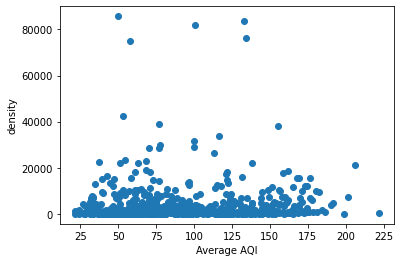

In [74]:
import matplotlib.pyplot as plt 

y = df2['density'].tolist()
x = df2['avg_AQI'].tolist()
plt.scatter(x,y)
plt.ylabel('density')
plt.xlabel('Average AQI')
plt.show()

[]

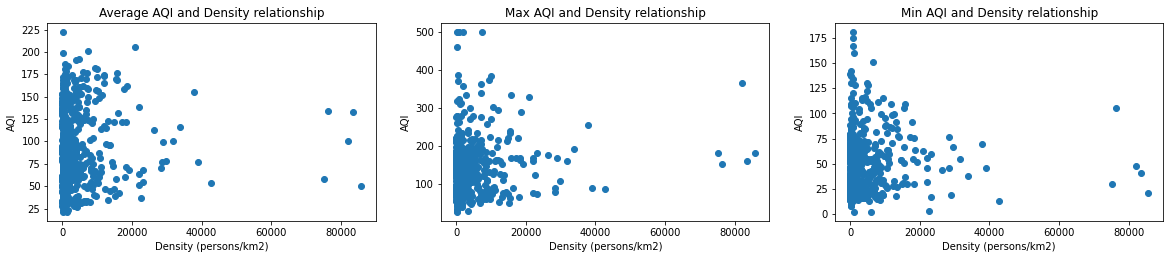

In [75]:
#Set the size of the matplotlib canvas
fig = plt.figure(figsize = (20,8))

#### Subplot 1###

plt.subplot(2,3,1)
#Add titles to the chart and axes
plt.title('Average AQI and Density relationship')
plt.ylabel('AQI')
plt.xlabel('Density (persons/km2)')
x = df2['density'].tolist()
y = df2['avg_AQI'].tolist()
plt.scatter(x,y)

#### Subplot 2 ###

plt.subplot(2,3,2)
#Add titles to the chart and axes
plt.title('Max AQI and Density relationship')
plt.ylabel('AQI')
plt.xlabel('Density (persons/km2)')
x = df2['density'].tolist()
y = df2['max_AQI'].tolist()
plt.scatter(x,y)

#### Subplot 2 ###

plt.subplot(2,3,3)
#Add titles to the chart and axes
plt.title('Min AQI and Density relationship')
plt.ylabel('AQI')
plt.xlabel('Density (persons/km2)')
x = df2['density'].tolist()
y = df2['min_AQI'].tolist()
plt.scatter(x,y)


plt.plot()



[]

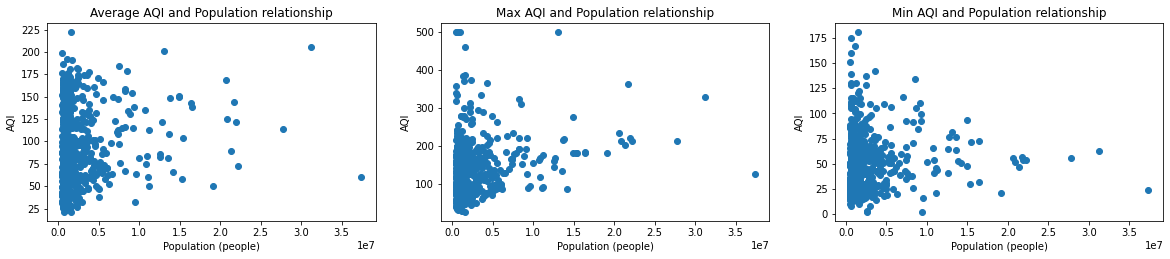

In [76]:
#Set the size of the matplotlib canvas
fig = plt.figure(figsize = (20,8))

#### Subplot 1###

plt.subplot(2,3,1)
#Add titles to the chart and axes
plt.title('Average AQI and Population relationship')
plt.ylabel('AQI')
plt.xlabel('Population (people)')
x = df2['Population'].tolist()
y = df2['avg_AQI'].tolist()
plt.scatter(x,y)

#### Subplot 2 ###

plt.subplot(2,3,2)
#Add titles to the chart and axes
plt.title('Max AQI and Population relationship')
plt.ylabel('AQI')
plt.xlabel('Population (people)')
x = df2['Population'].tolist()
y = df2['max_AQI'].tolist()
plt.scatter(x,y)

#### Subplot 2 ###

plt.subplot(2,3,3)
#Add titles to the chart and axes
plt.title('Min AQI and Population relationship')
plt.ylabel('AQI')
plt.xlabel('Population (people)')
x = df2['Population'].tolist()
y = df2['min_AQI'].tolist()
plt.scatter(x,y)


plt.plot()


In [85]:
from sklearn.cluster import KMeans

X = df1[['avg_AQI','density']]
X = X.to_numpy(dtype=float)
print(X)
kmean = KMeans(3,random_state=100).fit(X)

[[1.92278785e-01 6.94247756e-02]
 [9.19138258e-01 2.45183055e-01]
 [4.61312000e-01 5.11578090e-02]
 ...
 [9.47914018e-02 1.40335336e-02]
 [3.29153741e-01 4.54097189e-04]
 [1.70985842e-01 7.08034989e-04]]


In [86]:
# fig = plt.figure()
# fig = plt.figure(figsize = (12, 8), dpi=80)
# ax = fig.add_subplot(111, projection='3d')
# pnt3d = ax.scatter3D(df3['AQI'],df3 ['Population'], df3['gdp'],c=kmean.labels_.astype(float))
# cbar=plt.colorbar(pnt3d)
# cbar.set_label("Grinding Volume (cm3)")
# fig.set_facecolor('white')
# ax.set_facecolor('white')
# # plt.xticks(np.arange(2018, 2021, 1))
# # plt.yticks(np.arange(1,3,1))
# ax.set_xlabel('AQI')
# ax.set_ylabel('Population')
# ax.set_zlabel('gdp')
# plt.show()

In [87]:
df_label = df2.copy()
df_label['label'] = kmean.labels_

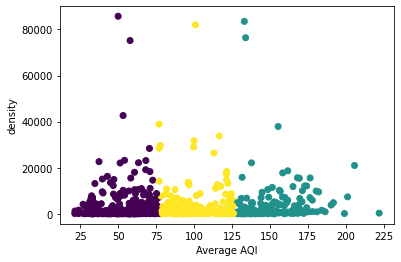

In [88]:
import matplotlib.pyplot as plt 

y = df2['density'].tolist()
x = df2['avg_AQI'].tolist()
plt.scatter(x,y,c=df_label['label'])
plt.ylabel('density')
plt.xlabel('Average AQI')
plt.show()

In [89]:
df_g1 = df_label[df_label['label']==1]
df_g1['label'].min()
minvalue_series = df_g1.min(skipna = False)
maxvalue_series = df_g1.max(skipna = False)
print('AQI min: ',minvalue_series['AQI'])
print('Population min: ',minvalue_series['Population'])
print('AQI max: ',maxvalue_series['AQI'])
print('Population max: ',maxvalue_series['Population'])
sql3 = "SELECT Country, count(*) from df_g1 GROUP BY Country ORDER BY count(*) DESC"
s2 = ps.sqldf(sql3,locals())
print(s2)

KeyError: 'AQI'

In [ ]:
df_g2 = df_label[df_label['label']==2]
df_g2
minvalue_series = df_g2.min(skipna = False)
maxvalue_series = df_g2.max(skipna = False)
print('AQI min: ',minvalue_series['AQI'])
print('Density min: ',minvalue_series['density'])
print('AQI max: ',maxvalue_series['AQI'])
print('Density max: ',maxvalue_series['density']) 
sql3 = "SELECT Country, count(*) from df_g2 GROUP BY Country ORDER BY count(*) DESC"
s2 = ps.sqldf(sql3,locals())
print(s2)

AQI min:  59.91304347826087
Density min:  4384.180126182965
AQI max:  205.87951807228916
Density max:  21011.708894878706
  Country  count(*)
0   Japan         1
1   India         1
2   China         1


In [ ]:
df_g3 = df_label[df_label['label']==3]
df_g3
minvalue_series = df_g3.min(skipna = False)
maxvalue_series = df_g3.max(skipna = False)
print('AQI min: ',minvalue_series['AQI'])
print('Density min: ',minvalue_series['density'])
print('AQI max: ',maxvalue_series['AQI'])
print('Density max: ',maxvalue_series['density'])
sql3 = "SELECT Country, count(*) from df_g3 GROUP BY Country ORDER BY count(*) DESC"
s2 = ps.sqldf(sql3,locals())
print(s2)

AQI min:  26.759036144578314
Density min:  6.626666981154327
AQI max:  182.18072289156626
Density max:  83467.88571428572
                  Country  count(*)
0                   China        23
1                   India        17
2                  Brazil         9
3               Indonesia         5
4                Pakistan         4
5                 Nigeria         4
6           United States         3
7             South Korea         3
8            South Africa         3
9                  Mexico         3
10                  Japan         3
11                  Italy         3
12               Colombia         3
13              Australia         3
14              Venezuela         2
15         United Kingdom         2
16                 Turkey         2
17                 Taiwan         2
18                   Iran         2
19                  Ghana         2
20                 Canada         2
21               Cameroon         2
22                Vietnam         1
23            

In [ ]:
df_g3 = df_label[df_label['label']==4]
df_g3
minvalue_series = df_g3.min(skipna = False)
maxvalue_series = df_g3.max(skipna = False)
print('AQI min: ',minvalue_series['AQI'])
print('Density min: ',minvalue_series['density'])
print('AQI max: ',maxvalue_series['AQI'])
print('Density max: ',maxvalue_series['density'])
sql3 = "SELECT Country, count(*) from df_g3 GROUP BY Country ORDER BY count(*) DESC"
s2 = ps.sqldf(sql3,locals())
print(s2)

AQI min:  32.19277108433735
Density min:  122.9825695334288
AQI max:  184.1939393939394
Density max:  76388.2831858407
           Country  count(*)
0            China        12
1            India         3
2            Spain         2
3            Japan         2
4          Vietnam         1
5    United States         1
6   United Kingdom         1
7         Tanzania         1
8            Sudan         1
9      South Korea         1
10    South Africa         1
11       Singapore         1
12    Saudi Arabia         1
13          Russia         1
14         Myanmar         1
15          Mexico         1
16        Malaysia         1
17     Ivory Coast         1
18            Iraq         1
19            Iran         1
20       Hong Kong         1
21           Egypt         1
22          Canada         1
23          Brazil         1
24          Angola         1


In [ ]:
df_g3 = df_label[df_label['label']==5]
df_g3
minvalue_series = df_g3.min(skipna = False)
maxvalue_series = df_g3.max(skipna = False)
print('AQI min: ',minvalue_series['AQI'])
print('Density min: ',minvalue_series['density'])
print('AQI max: ',maxvalue_series['AQI'])
print('Density max: ',maxvalue_series['density'])
sql3 = "SELECT Country, count(*) from df_g3 GROUP BY Country ORDER BY count(*) DESC"
s2 = ps.sqldf(sql3,locals())
print(s2)

AQI min:  49.88414634146341
Density min:  1273.3422704283712
AQI max:  168.9939024390244
Density max:  85697.82959641256
      Country  count(*)
0      Mexico         1
1       Japan         1
2       India         1
3       Egypt         1
4       China         1
5      Brazil         1
6  Bangladesh         1


In [ ]:
# Read Traffic index by COuntry
def read_traffic(path=''):
    df = pd.read_csv(path)
    return df

In [ ]:
df_traffic = read_traffic(path='../vehicle-density/CSV_file_data/vehicle-density.csv')
df_traffic

,country,traffic index,co2 emission index
0,Nigeria,307.47,7925.70
1,Costa Rica,300.05,9028.50
2,Sri Lanka,272.63,7417.02
3,Kenya,271.87,8106.21
4,Bangladesh,258.31,5065.06
...,...,...,...
80,Bosnia And Herzegovina,89.54,2521.34
81,Finland,88.60,1811.54
82,Denmark,88.37,1654.14
83,Estonia,85.39,2118.77


In [ ]:
print(len(df_label['Country'].unique()))

134
